# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Isotropic metrics

In this notebook, we solve isotropic eikonal equations on the CPU and the GPU, and check that they produce consistent results.

We obtain substantial accelerations on sufficiently large instances, a few million points, by a factor up to $100$. Note that smaller test cases yield less acceleration, due to the difficulty to extract parallelism.

**bit-consistency.** By design, the CPU and GPU codes produce the same values, up to machine precision, which is approximately $10^{-8}$ for floating point types, in a variety on situations. 
This is due to the fact that the two implementations, although widely different, solve the same discretized problem. We try to ensure this behavior and check it as much as possible, as it is a strong indicator of the validity of the implementations. We refer to it as bit-consistency, aknowledging that it is a bit abusive, since the algorithm outputs, while extremely close, are still far from a bit-for-bit match.

**GPU/CPU speedup.**  General purpose graphical processors are massively parallel machines, which greatly outperform CPUs on embarassingly parallel tasks. The acceleration due to GPUs is therefore most impressive on large test cases.

In [1]:
large_instances = False # Set to True to show off GPU acceleration (CPU times may become a big long.)

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Three dimensions](#1.-Three-dimensions)
  * [2. Two dimensions](#2.-Two-dimensions)
  * [3. GPU specific options](#3.-GPU-specific-options)
    * [3.1 Multiprecision and convergence tolerance](#3.1-Multiprecision-and-convergence-tolerance)
    * [3.2 Block shape and inner iterations](#3.2-Block-shape-and-inner-iterations)
    * [3.3 Periodicity](#3.3-Periodicity)
    * [3.4 Help and parameter defaults](#3.4-Help-and-parameter-defaults)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
Eikonal.dictIn.default_mode = 'gpu'

In [29]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen
    Eikonal,ad,cugen = rreload([Eikonal,ad,cugen],"..")
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Decorations for gpu usage

Dealing with GPU data induces minor inconveniences:
- GPU arrays are not implicitly convertible to CPU arrays, and this is a good thing since memory transfers from GPU memory to CPU memory, and conversely, are not cheap. The `get` method must be applied to a cupy array to retrieve a numpy array.
- GPU computing is much more efficient with 32 bit data types, integer and floating point, than with their 64bit counterparts. However a number of numpy and cupy basic functions default to 64bit output, which will be inconsistent with the rest of computations.

We provide decorators to perform these memory transfers and data type conversions automatically. They are only applied to specific modules and functions, below, to avoid excessive implicit operations. 

In [6]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

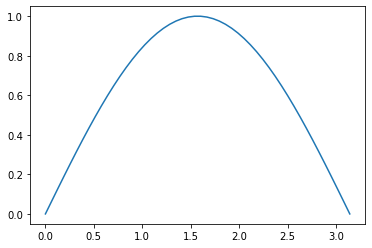

In [7]:
X = cp.linspace(0,np.pi) # 64 bit output is converted to 32 bit by decorator
plt.plot(X,np.sin(X));   # GPU array is transfered to CPU memory.

Note that, by default, these decorators do not apply to the system module, but only to a shallow copy.

In [8]:
sys.modules['cupy'].linspace(0,np.pi).dtype

dtype('float64')

### 0.2 Comparing CPU and GPU results

In [9]:
variants_basic = (
    [{},{"seedRadius":2.}], # Spread seed information ?
    [{},{'multiprecision':True}] # Reduce floating point roundoff errors
)

variants_ext = (
    [{},{'order':2}], # second order scheme ?
    [{},{"seedRadius":2.},{"factoringRadius":10.,'factoringPointChoice':'Key'}], # source factorization ?
    [{},{'multiprecision':True}] # Reduce floating point roundoff errors
)

In [10]:
def RunCompare(gpuIn,check=True,check_ratio=0,variants=None,**kwargs):
    # Dispatch the common variants if requested
    if isinstance(variants,str): variants = {'basic':variants_basic,'ext':variants_ext}[variants]
    if variants:
        for variant in variants[0]:
            RunCompare(gpuIn,check=check,check_ratio=check_ratio,variants=variants[1:],**kwargs,**variant)
        return

    if kwargs: print("\n",f"--- Variant {kwargs} ---")

    # Run the CPU and GPU solvers
    gpuIn = gpuIn.copy(); gpuIn.update(kwargs)
    gpuOut = gpuIn.Run()
    if gpuIn.get('verbosity',1):  print(f"--- gpu done, turning to cpu ---")
    cpuOut = gpuIn.Run(join={'mode':'cpu_transfer'})
    
    # Print performance info
    fmTime = cpuOut['FMCPUTime']; stencilTime = cpuOut['StencilCPUTime']; 
    cpuTime = fmTime+stencilTime; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    
    # Check consistency 
    cpuVals = cpuOut['values'].copy(); gpuVals = gpuOut['values'].get()
    # Inf is a legitimate value in the presence of e.g. obstacles
    commonInfs = np.logical_and(np.isinf(cpuVals),np.isinf(gpuVals)) 
    cpuVals[commonInfs]=0; gpuVals[commonInfs]=0
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuVals-cpuVals))
    
    if check is True: assert np.allclose(gpuVals,cpuVals,atol=1e-5,rtol=1e-4)
    elif check is False: pass
    else: assert np.sum(np.abs(gpuVals-cpuVals)>check)<=check_ratio*gpuVals.size

    return gpuOut,cpuOut

## 1. Three dimensions

GPU acceleration shines particularly well in three dimensions, where we get accelerations by a factor $100$ on large instances.

In [30]:
ReloadPackages()

In [31]:
n = 200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Isotropic3',
    'seed':[0.,0.5,1.],
    'exportValues':1,
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [12]:
RunCompare(hfmIn);

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.05199599266052246 seconds, and 65 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.124 s.
Solver time (s). GPU : 0.05199599266052246, CPU : 1.1340000000000001. Device acceleration : 21.809373030029302
Max |gpuValues-cpuValues| :  6.332993507385254e-07


We check bit-consistency for a few variants of the scheme.

In [32]:
n=50; hfmInS = hfmIn.copy() # Define the a smaller instance
hfmInS.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'seed':[0,0,0],
    'cost': np.prod(np.sin(2*np.pi*X),axis=0) + 1.1, # Non-constant cost
    'verbosity':0,
})

In [33]:
RunCompare(hfmInS,variants='basic');

Solver time (s). GPU : 0.016496896743774414, CPU : 0.11900000000000001. Device acceleration : 7.213477895162806
Max |gpuValues-cpuValues| :  6.903636284860681e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.021500587463378906, CPU : 0.116. Device acceleration : 5.395201419383455
Max |gpuValues-cpuValues| :  1.5621205884386313e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.01650691032409668, CPU : 0.111. Device acceleration : 6.724456474326569
Max |gpuValues-cpuValues| :  7.111670792259162e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.02097630500793457, CPU : 0.115. Device acceleration : 5.482376422182062
Max |gpuValues-cpuValues| :  1.1188518178606444e-07


The second order scheme implementation, and the source factorization, have some slight differences between the GPU and CPU implementation, hence *one cannot expect bit-consistency in general*. 

In [34]:
RunCompare(hfmInS,variants='ext',check=0.02);

Solver time (s). GPU : 0.016480207443237305, CPU : 0.112. Device acceleration : 6.796030959304429
Max |gpuValues-cpuValues| :  6.903636284860681e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.021502256393432617, CPU : 0.114. Device acceleration : 5.301769168505439
Max |gpuValues-cpuValues| :  1.5621205884386313e-07

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.016505002975463867, CPU : 0.114. Device acceleration : 6.906996634261199
Max |gpuValues-cpuValues| :  7.111670792259162e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.018479108810424805, CPU : 0.11. Device acceleration : 5.9526680170823285
Max |gpuValues-cpuValues| :  1.1188518178606444e-07

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.01849675178527832, CPU : 0.11800000000000001. Device acceleration : 6.379498485453913
Max |gpuValues-cpuValues| :  0.0016292832261056156

 --- Variant {'factor

## 2. Two dimensions

In two dimensions, it is usually more difficult to extract parallism than in three dimensions.
Indeed, the front propagated in the computations is expected to have approximately
$$
    N^{\frac{d-1} d}
$$
points in dimension $d$, where $N$ denotes the total number of points in the domain. 
The front in a two dimensional computation thus has $N^{\frac 1 2}$ points which is much fewer than $N^{\frac 2 3}$ in three dimensions, when $N$ is large. In addition the number of points $N$ is also often fewer in two dimensional problems.

In [ ]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.,0.5],
    'exportValues':1,
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [ ]:
sum(e in {1,2,3} for e in [1,4,2])

In [ ]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-4)

Another annoyance is that the numerical error, close to $10^{-4}$ in the large instance, is not as good as could be expected, around $10^{-7}$ for single precision floating point types. 
A quick fix, explained in more detail below and which does have a computational cost, is to run the computation using multiprecision.

In [ ]:
gpuOut = hfmIn.Run(join={'multiprecision':True}) # join with another dict
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

In [ ]:
n=50; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost':np.prod(np.sin(2*np.pi*X),axis=0) +1.1, # Non-constant cost
    'verbosity':0,
})

In [ ]:
RunCompare(hfmInS,variants='basic')

Again, bit consistency is not expected with the second order scheme.

<!---
, but not excluded either.
Note that the second order scheme is non-monotone, hence the solution values need not decrease as the iterations proceed. 
In order to be consistent with the CPU implementation, and validate this test, we set the trait `decreasing_macro` to $0$.
--->

In [ ]:
RunCompare(hfmInS,variants='ext',check=0.02)

## 3. GPU specific options

The RunGPU method of the HFM has a number of parameters, usually set to reasonnable defaults. We discuss a few of them below.

### 3.1 Multiprecision and convergence tolerance

**Multiprecision.** In this mode, the solution values are represented as pairs 
$$
    u(x) = u_q(x) \delta + u_r(x),
$$
where $u_q(x) \in Z$ is an integer, $\delta>0$ is a fixed scale, and $u_r(x) \in [-\delta/2,\delta/2[$.

The parameter $\delta$ is set automatically as the largest power of two (usually a negative power) bounded by $h/10$, where $h$ is the grid scale. The choice of a power of two avoids roundoff errors.

<!---
Eventually, the result is converted to floating point format. A slightly better accuracy can be obtained by using a double type in this last step.
gpuOut = RunGPU({**hfmIn,'values_float64':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
--->

**Convergence tolerance.** This parameter sets the tolerance for the convergence of the fixed point solver.
When setting the convergence tolerance, it is important to keep in mind the *resolution* of the chosen floating point type.

In [ ]:
np.finfo(np.float32)

In [ ]:
np.finfo(np.float64)

A typical value for tolerance, in *multi-precision* mode is 
$$
    tol=res*h*M,
$$
where $h$ is the grid scale, $res$ is the resolution of the floating point type, and $M$ is the magnitude of cost function in the case of an isotropic metric, or a related quantity in the anisotropic case.

Without multiprecision, the above tolerance value should be multiplied by the grid scale.

Caveats:
- Choosing an excessively small tolerance, may increase the number of iterations of the solver (especially in multi-precision mode according to our experiments). In fact, the solver may not converge at all.
- Choosing a excessively large tolerance may reduce accuracy.

### 3.2 Block shape and inner iterations

The GPU implementation of the fast marching method works by grouping together blocks of grid points, which are updated simultaneously a prescribed number of times. The shape of these blocks ` shape_i`  and number of iterations `niter_i` can be modified, which may affect performance. They are collected in the `traits` input parameter, together with a number of compile time constants and typedefs for the GPU kernel.

In [ ]:
gpuOut['keys']['default']['traits']

### 3.3 Periodicity

Standard periodic boundary conditions may be applied to one or several some axes.

In [ ]:
n=48
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.2,0.4],
    'exportValues':1,
    'cost':1.,
    'verbosity':1,
    'periodic':(False,True) # Periodic along second axis
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=False)

In [ ]:
gpuOut = hfmIn.Run()

In [ ]:
X = hfmIn.Grid()
plt.title('Periodic solution'); plt.axis('equal')
plt.contour(*X,gpuOut['values']); 

### 3.4 Help and parameter defaults

The HFM algorithm sets a number of parameters to (hopefull relevant) default values. 
Setting a verbosity equal or larger than two will display some of the associated values.

In [ ]:
n=200
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.,0.5],
    'exportValues':1,
    'cost':1.,
    'verbosity':2
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [ ]:
gpuOut = hfmIn.Run()

The default values of the keys and values are provided in the output.

In [ ]:
gpuOut['keys']['default']

A succint help on the role of each key can be displayed.

In [ ]:
gpuOut['keys']['help']